# A Business Case for Predictive Pipeline Maintenance

## IE Sustainability Datathon 2023

### Tech4Planet: https://github.com/orgs/tech4plannet/


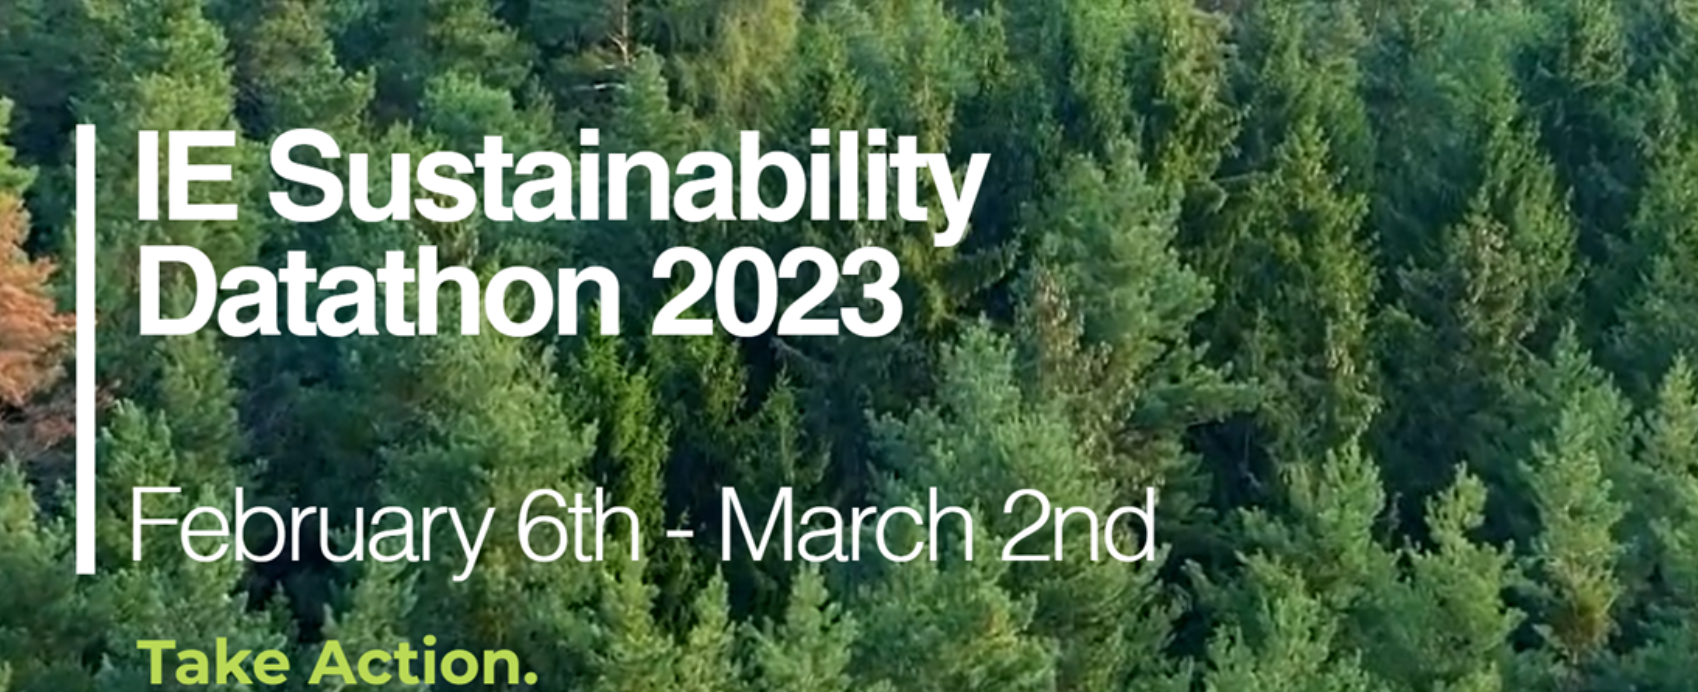

### ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Structure of these series of Jupyter Notebooks
### ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

### 1. EDA

### 2. Inspection Strategy

### 3. Data Wrangling and Feature Engineering

### 4. Preparing Data Submission Sample

### 5. Random Forest

### 6. PCA, XGBoost and other approaches

### ==========================================================================
## You are in Notebook 5: Random Forest (5/6)
### ==========================================================================

# <font color=green> Table of contents </font>

* [__1. Libraries Used__](#1)  
* [__2. Loading Datasets__](#2)  
* [__3. Standardizing Data__](#3)  
* [__4. Correlation__](#4)  
* [__5. Splitting Unbalanced Dataset__](#5)  
* [__6. Random Forest__](#6)  
* [__7. K-Fold Cross Validation__](#7)  
* [__8. Fitting Model and Results__](#8)  
* [__9. Additional Baselines__](#9)

<a id='1'></a>
# <font color=green> 1. Libaries used </font>

## <font color=green> 1.1 Requirements </font>

In [ ]:
#perform al #pip installs in one go comment out if already installed
#pip install pandas
#pip install numpy
#pip install matplotlib
#pip install seaborn
#pip install sklearn
#pip install scipy
#pip install statsmodels
#pip install plotly
#pip install cufflinks
#pip install squarify
#pip install yellowbrick
#pip install lazypredict
#pip install pandas_profiling

## <font color=green> 1.2 Imports </font>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns  
import matplotlib.pyplot as plt
import plotly.io as pio
import os
import matplotlib
import warnings

#from imblearn.over_sampling import SMOTE


#to enable the inline plotting
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

sns.set_style("darkgrid")

In [2]:
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import classification_report

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
#rfc using regularization and gridsearch to find the best parameters for the model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy.stats import normaltest
from sklearn.model_selection import StratifiedKFold

from pandas_profiling import ProfileReport


import lazypredict
from lazypredict.Supervised import LazyClassifier

from sklearn.preprocessing import MinMaxScaler


warnings.simplefilter(action='ignore', category=FutureWarning)

## <font color=green> 1.3 Functions </font>

In [3]:
# Function for EDA. Using the display() function to have  well-formatted tables. We are mainly using pandas to explore the datasets

def dataset_description(df_target):

    print('This is the Dataset shape: %s\n' % (df_target.shape, ))
    print('Dataset columns: %s\n' % df_target.columns)

    print('\nColumns description:\n')
    display(df_target.info())
    display(df_target.describe())  # describe the dataset

    print('\nNull values:\n')
    display(df_target.isnull().sum())  # Identify null values

#function performing a quick check on df_inspection to have best of pandas functions separated by a line
def quick_check(dataframe):
    print('First 5 rows %s\n')
    print(dataframe.head(2))
    print("=====================================")
    print('Dataframe shape %s\n')
    print(dataframe.shape)
    print("=====================================")
    print('Dataframe describe categorical %s\n')
    print(dataframe.describe(include=['O']))
    print("=====================================")
    print('Dataframe null values %s\n')
    print(dataframe.isnull().sum())
    print("=====================================")
    print('Dataframe value counts %s\n')
    print(dataframe.value_counts())
    print("=====================================")

#stats function
def stats(dataframe):
    print('Dataframe correlation %s\n')
    print(dataframe.corr())
    print("=====================================")
    print('Dataframe covariance %s\n')
    print(dataframe.cov())
    print("=====================================")
    print('Dataframe skew %s\n')
    print(dataframe.skew())
    print("=====================================")
    print('Dataframe kurtosis %s\n')
    print(dataframe.kurt())
    print("=====================================")

#create a function to normalize characters from a dataset's column in Spanish
def normalize_characters(df, column):
    df[column] = df[column].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
    df[column] = df[column].str.lower()
    df[column] = df[column].str.replace('á', 'a')
    df[column] = df[column].str.replace('é', 'e')
    df[column] = df[column].str.replace('í', 'i')
    df[column] = df[column].str.replace('ó', 'o')
    df[column] = df[column].str.replace('ú', 'u')
    df[column] = df[column].str.replace('ñ', 'n')
    df[column] = df[column].str.replace('ü', 'u')
    df[column] = df[column].str.replace('ç', 'c')
    df[column] = df[column].str.replace('(', '')
    df[column] = df[column].str.replace(')', '')
    df[column] = df[column].str.replace('\'', '')
    df[column] = df[column].str.replace('´', '')
    df[column] = df[column].str.replace('`', '')
    df[column] = df[column].str.replace('’', '')
    return df.head(2)

#create function to change detypes in64 to int32 in a df
def change_dtypes(df):
    for col in df.columns:
        if df[col].dtype == 'int64':
            df[col] = df[col].astype('int32')
        elif df[col].dtype == 'float64':
            df[col] = df[col].astype('float32')
    return df.head(2)

def outlier_function(df, col_name):
    """ this function detects first and third quartile and interquartile range for a given column of a dataframe
    then calculates upper and lower limits to determine outliers conservatively
    returns the number of lower and uper limit and number of outliers respectively"""
    first_quartile = np.percentile(np.array(df[col_name].tolist()), 25)
    third_quartile = np.percentile(np.array(df[col_name].tolist()), 75)
    IQR = third_quartile - first_quartile
                        
    upper_limit = third_quartile+(3*IQR)
    lower_limit = first_quartile-(3*IQR)
    outlier_count = 0
                    
    for value in df[col_name].tolist():
        if (value < lower_limit) | (value > upper_limit):
            outlier_count +=1
        else:
            pass
    return lower_limit, upper_limit, outlier_count

In [4]:
#show all print outputs when using a function
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#display all columns
pd.set_option('display.max_columns', None)


<a id='2'></a>
# <font color=green> 2. Loading Datasets</font>

In [5]:
#point to the folder where the data is stored
os.chdir(r"C:\Users\JuanHorrillo\OneDrive - IE Students\Documents\Masters\Sustainability\csvs\230222")

# Loading combined_mod dataset
train_consolidated = pd.read_csv('train_consolidated_with_outliers_and_pop.csv')
sample_submission = pd.read_csv('submission_for_outliers_220223_with_pop.csv')

We need to have both datasets have the same order in the columns

In [6]:
#put the same order for the columns in train_consolidated and sample_submission
train_consolidated = train_consolidated[sample_submission.columns]


In [7]:
#check nulls in sample_submission 
sample_submission.isnull().sum()


PipeId                                          0
Incidence                                       0
Province                                        0
Town                                            0
YearBuilt                                       0
Diameter                                        0
Length                                          0
Pressure                                        0
NumConnections                                  0
NumConnectionsUnder                             0
BoolBridle                                      0
aspect                                          0
Relative_Thickness                              0
pipe_area                                       0
Total_Connections                               0
area_connection                                 0
connection_bool                                 0
gas_natural                                     0
Material_Acrylonitrile-Butadiene-Styrene        0
Material_Copper                                 0


## <font color=green> 2.1. Filling Nulls in sample submission file</font>


In [8]:
#fill the nulls in No_Inspectio with 1
sample_submission['No_Inspections'].fillna(1, inplace=True)


In [9]:
#fill the nulls in average_severity_pipe  with the mean of the column
sample_submission['average_severity_pipe'].fillna(sample_submission['average_severity_pipe'].mean(), inplace=True)

In [10]:
#fill nulls in relative_risk by multyplying No_Incidences by  average_severity_pipe
sample_submission['relative_risk'] = sample_submission['No_Previous_Incidences'] * sample_submission['average_severity_pipe']

In [11]:
#fill nulls in preventive_maintenance_rate by dividing relative_risk by No_Inspections
sample_submission['preventive_maintenance_rate'] = sample_submission['relative_risk'] / sample_submission['No_Inspections']

In [12]:
#fill the nulls in Probability_rate with No_Previous_Incidences divided by No_Inspections
sample_submission['Probability_rate'] = sample_submission['No_Previous_Incidences'] / sample_submission['No_Inspections']


In [13]:
sample_submission.dtypes

PipeId                                        int64
Incidence                                     int64
Province                                     object
Town                                         object
YearBuilt                                   float64
Diameter                                    float64
Length                                      float64
Pressure                                    float64
NumConnections                                int64
NumConnectionsUnder                           int64
BoolBridle                                    int64
aspect                                      float64
Relative_Thickness                          float64
pipe_area                                   float64
Total_Connections                             int64
area_connection                             float64
connection_bool                               int64
gas_natural                                   int64
Material_Acrylonitrile-Butadiene-Styrene      int64
Material_Cop

In [15]:
#drop Province, Town from sample_submission
sample_submission.drop(['Province', 'Town','Area (sq km)', 'Population'], axis=1, inplace=True)

<a id='3'></a>
# <font color=green> 3. Standardizing data </font>

In [16]:
sample_submission.head(1)

PipeId  Incidence  YearBuilt  Diameter  Length  Pressure  \
0  446859944          0    2012.00      0.11   44.29      0.15   

   NumConnections  NumConnectionsUnder  BoolBridle  aspect  \
0               0                    0           0   60.39   

   Relative_Thickness  pipe_area  Total_Connections  area_connection  \
0                0.73      15.30                  0             0.00   

   connection_bool  gas_natural  Material_Acrylonitrile-Butadiene-Styrene  \
0                0            1                                         0   

   Material_Copper  Material_Fiberglass-Reinforced Plastic  \
0                0                                       0   

   Material_Polyethylene  Material_Polypropylene  Diameter2  Length2  \
0                      1                       0       0.01  1961.25   

   Pressure2  Average yearly temperature (°C)  Min. Temperature (°C)  \
0       0.02                            17.62                   6.60   

   Max. Temperature (°C)  Yearly Rainfall (mm)  Average year Humidity (%)  \
0                  30.80                   427                       0.64   

   Rainy days per year (days)  Yearly Sun Hours (hours)  No_Inspections  \
0                          46                    113.20            5.00   

   average_severity_pipe  Average_MonthsLastRev  pipe_inspected_frequently  \
0                   4.00                  20.75                       1.00   

   No_Previous_Incidences  No_Previous_Severity_High  \
0                    0.00                       0.00   

   No_Previous_Severity_Medium  No_Previous_Severity_Low  InspectionYear  \
0                         0.00                      0.00         2021.00   

   MonthsLastRev  relative_risk  preventive_maintenance_rate  \
0          24.00           0.00                         0.00   

   Probability_rate  Age_pipe_at_inspection  Population density (persons/sqkm)  
0              0.00                    9.00                             239.60

In [17]:
sample_submission.columns

Index(['PipeId', 'Incidence', 'YearBuilt', 'Diameter', 'Length', 'Pressure',
       'NumConnections', 'NumConnectionsUnder', 'BoolBridle', 'aspect',
       'Relative_Thickness', 'pipe_area', 'Total_Connections',
       'area_connection', 'connection_bool', 'gas_natural',
       'Material_Acrylonitrile-Butadiene-Styrene', 'Material_Copper',
       'Material_Fiberglass-Reinforced Plastic', 'Material_Polyethylene',
       'Material_Polypropylene', 'Diameter2', 'Length2', 'Pressure2',
       'Average yearly temperature (°C)', 'Min. Temperature (°C)',
       'Max. Temperature (°C)', 'Yearly Rainfall (mm)',
       'Average year Humidity (%)', 'Rainy days per year (days)',
       'Yearly Sun Hours (hours)', 'No_Inspections', 'average_severity_pipe',
       'Average_MonthsLastRev', 'pipe_inspected_frequently',
       'No_Previous_Incidences', 'No_Previous_Severity_High',
       'No_Previous_Severity_Medium', 'No_Previous_Severity_Low',
       'InspectionYear', 'MonthsLastRev', 'relative_risk',

In [19]:
#Use minmax scaler to scale these columns in sample_submission: 
# 'YearBuilt', 'Diameter','Length', 'Pressure', 'NumConnections', 'NumConnectionsUnder', 'aspect', 'Relative_Thickness', 'pipe_area', 'Total_Connections', 'area_connection', 'Diameter2', 'Length2', 'Pressure2', 'Average yearly temperature (°C)', 'Min. Temperature (°C)', 'Max. Temperature (°C)', 'Yearly Rainfall (mm)', 'Average year Humidity (%)', 'Rainy days per year (days)', 'Yearly Sun Hours (hours)','No_Inspections', 'average_severity_pipe', 'Average_MonthsLastRev',
#       'No_Previous_Incidences', 'relative_risk', 'preventive_maintenance_rate',
#       'Probability_rate', 'No_Inspections', 'average_severity_pipe',
#       'relative_risk', 'preventive_maintenance_rate', 'Probability_rate'

scaler = MinMaxScaler()

sample_submission[['YearBuilt', 'Diameter','Length', 'Pressure', 'NumConnections', 'NumConnectionsUnder', 'aspect', 'Relative_Thickness', 'pipe_area', 'Total_Connections', 'area_connection', 'Diameter2', 'Length2', 'Pressure2', 'Average yearly temperature (°C)', 'Min. Temperature (°C)', 'Max. Temperature (°C)', 'Yearly Rainfall (mm)', 'Average year Humidity (%)', 'Rainy days per year (days)', 'Yearly Sun Hours (hours)','No_Inspections', 'average_severity_pipe', 'Average_MonthsLastRev',
       'No_Previous_Incidences', 'relative_risk', 'preventive_maintenance_rate',
       'Probability_rate', 'No_Inspections', 'average_severity_pipe',
       'relative_risk', 'preventive_maintenance_rate', 'Probability_rate', 'InspectionYear',  'MonthsLastRev','Age_pipe_at_inspection', 'Population density (persons/sqkm)']] = scaler.fit_transform(sample_submission[['YearBuilt', 'Diameter','Length', 'Pressure', 'NumConnections', 'NumConnectionsUnder', 'aspect', 'Relative_Thickness', 'pipe_area', 'Total_Connections', 'area_connection', 'Diameter2', 'Length2', 'Pressure2', 'Average yearly temperature (°C)', 'Min. Temperature (°C)', 'Max. Temperature (°C)', 'Yearly Rainfall (mm)', 'Average year Humidity (%)', 'Rainy days per year (days)', 'Yearly Sun Hours (hours)','No_Inspections', 'average_severity_pipe', 'Average_MonthsLastRev',
       'No_Previous_Incidences', 'relative_risk', 'preventive_maintenance_rate',
       'Probability_rate', 'No_Inspections', 'average_severity_pipe',
       'relative_risk', 'preventive_maintenance_rate', 'Probability_rate', 'InspectionYear', 'MonthsLastRev','Age_pipe_at_inspection', 'Population density (persons/sqkm)']])
sample_submission.head(1)

PipeId  Incidence  YearBuilt  Diameter  Length  Pressure  \
0  446859944          0       0.82      0.17    0.01      0.00   

   NumConnections  NumConnectionsUnder  BoolBridle  aspect  \
0            0.00                 0.00           0    0.00   

   Relative_Thickness  pipe_area  Total_Connections  area_connection  \
0                0.03       0.00               0.00             0.00   

   connection_bool  gas_natural  Material_Acrylonitrile-Butadiene-Styrene  \
0                0            1                                         0   

   Material_Copper  Material_Fiberglass-Reinforced Plastic  \
0                0                                       0   

   Material_Polyethylene  Material_Polypropylene  Diameter2  Length2  \
0                      1                       0       0.03     0.00   

   Pressure2  Average yearly temperature (°C)  Min. Temperature (°C)  \
0       0.00                             0.86                   0.77   

   Max. Temperature (°C)  Yearly Rainfall (mm)  Average year Humidity (%)  \
0                   0.64                  0.15                       0.38   

   Rainy days per year (days)  Yearly Sun Hours (hours)  No_Inspections  \
0                        0.20                      0.83            0.36   

   average_severity_pipe  Average_MonthsLastRev  pipe_inspected_frequently  \
0                   1.00                   0.21                       1.00   

   No_Previous_Incidences  No_Previous_Severity_High  \
0                    0.00                       0.00   

   No_Previous_Severity_Medium  No_Previous_Severity_Low  InspectionYear  \
0                         0.00                      0.00            0.00   

   MonthsLastRev  relative_risk  preventive_maintenance_rate  \
0           0.23           0.00                         0.00   

   Probability_rate  Age_pipe_at_inspection  Population density (persons/sqkm)  
0              0.00                    0.17                               0.28

Sample submission is now standardized

<a id='4'></a>
# <font color=green> 4. Correlation</font>


In [20]:
#grpah correlation matrix in sample_submission
corr_matrix = sample_submission.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.99)]
to_drop


['Total_Connections', 'relative_risk', 'Age_pipe_at_inspection']

In [21]:
sample_submission.corr()['Incidence'].sort_values(ascending=False)


Incidence                                   1.00
area_connection                             0.00
Pressure                                    0.00
Pressure2                                   0.00
average_severity_pipe                       0.00
YearBuilt                                   0.00
aspect                                      0.00
Population density (persons/sqkm)           0.00
Material_Acrylonitrile-Butadiene-Styrene    0.00
PipeId                                      0.00
No_Previous_Severity_Medium                 0.00
Length                                      0.00
No_Inspections                              0.00
NumConnections                              0.00
Total_Connections                           0.00
Average year Humidity (%)                   0.00
connection_bool                             0.00
pipe_area                                   0.00
Material_Fiberglass-Reinforced Plastic      0.00
InspectionYear                              0.00
Rainy days per year 

In [22]:
#DROP Total_Connections IN sample_submission
sample_submission.drop(['Total_Connections'], axis=1, inplace=True)

In [23]:
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', mask=np.triu(corr_matrix, k=1))
plt.title('Correlation matrix for sample_submission')
plt.show()


<Figure size 2000x2000 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Correlation matrix for sample_submission')

Repeating process in train file

In [24]:
#checking nulls in train_consolidated
train_consolidated.isnull().sum()

PipeId                                      0
Incidence                                   0
Province                                    0
Town                                        0
YearBuilt                                   0
Diameter                                    0
Length                                      0
Pressure                                    0
NumConnections                              0
NumConnectionsUnder                         0
BoolBridle                                  0
aspect                                      0
Relative_Thickness                          0
pipe_area                                   0
Total_Connections                           0
area_connection                             0
connection_bool                             0
gas_natural                                 0
Material_Acrylonitrile-Butadiene-Styrene    0
Material_Copper                             0
Material_Fiberglass-Reinforced Plastic      0
Material_Polyethylene             

In [25]:
train_consolidated.dtypes

PipeId                                        int32
Incidence                                     int32
Province                                     object
Town                                         object
YearBuilt                                   float32
Diameter                                    float32
Length                                      float32
Pressure                                    float32
NumConnections                                int32
NumConnectionsUnder                           int32
BoolBridle                                    int32
aspect                                      float32
Relative_Thickness                          float32
pipe_area                                   float32
Total_Connections                             int32
area_connection                             float32
connection_bool                               int32
gas_natural                                   int32
Material_Acrylonitrile-Butadiene-Styrene      int32
Material_Cop

In [26]:
train_consolidated.columns

Index(['PipeId', 'Incidence', 'Province', 'Town', 'YearBuilt', 'Diameter',
       'Length', 'Pressure', 'NumConnections', 'NumConnectionsUnder',
       'BoolBridle', 'aspect', 'Relative_Thickness', 'pipe_area',
       'Total_Connections', 'area_connection', 'connection_bool',
       'gas_natural', 'Material_Acrylonitrile-Butadiene-Styrene',
       'Material_Copper', 'Material_Fiberglass-Reinforced Plastic',
       'Material_Polyethylene', 'Material_Polypropylene', 'Diameter2',
       'Length2', 'Pressure2', 'Average yearly temperature (°C)',
       'Min. Temperature (°C)', 'Max. Temperature (°C)',
       'Yearly Rainfall (mm)', 'Average year Humidity (%)',
       'Rainy days per year (days)', 'Yearly Sun Hours (hours)',
       'No_Inspections', 'average_severity_pipe', 'Average_MonthsLastRev',
       'pipe_inspected_frequently', 'No_Previous_Incidences',
       'No_Previous_Severity_High', 'No_Previous_Severity_Medium',
       'No_Previous_Severity_Low', 'InspectionYear', 'MonthsLastRe

In [27]:
#drop 'MaintenanceId', InspectionDate, Province, Province, 'Severity_high', 'Severity_medium', 'Severity_low'
train_consolidated.drop(['Province', 'Town', 'Area (sq km)', 'Population'], axis=1, inplace=True)

In [28]:
#difference in columns between train_consolidated and sample_submission
set(train_consolidated.columns) - set(sample_submission.columns)


{'Total_Connections'}

In [29]:
scaler = MinMaxScaler()

train_consolidated[['YearBuilt', 'Diameter','Length', 'Pressure', 'NumConnections', 'NumConnectionsUnder', 'aspect', 'Relative_Thickness', 'pipe_area', 'Total_Connections', 'area_connection', 'Diameter2', 'Length2', 'Pressure2', 'Average yearly temperature (°C)', 'Min. Temperature (°C)', 'Max. Temperature (°C)', 'Yearly Rainfall (mm)', 'Average year Humidity (%)', 'Rainy days per year (days)', 'Yearly Sun Hours (hours)','No_Inspections', 'average_severity_pipe', 'Average_MonthsLastRev',
       'No_Previous_Incidences', 'relative_risk', 'preventive_maintenance_rate',
       'Probability_rate', 'No_Inspections', 'average_severity_pipe',
       'relative_risk', 'preventive_maintenance_rate', 'Probability_rate', 'InspectionYear',  'MonthsLastRev','Age_pipe_at_inspection', 'Population density (persons/sqkm)']] = scaler.fit_transform(train_consolidated[['YearBuilt', 'Diameter','Length', 'Pressure', 'NumConnections', 'NumConnectionsUnder', 'aspect', 'Relative_Thickness', 'pipe_area', 'Total_Connections', 'area_connection', 'Diameter2', 'Length2', 'Pressure2', 'Average yearly temperature (°C)', 'Min. Temperature (°C)', 'Max. Temperature (°C)', 'Yearly Rainfall (mm)', 'Average year Humidity (%)', 'Rainy days per year (days)', 'Yearly Sun Hours (hours)','No_Inspections', 'average_severity_pipe', 'Average_MonthsLastRev',
       'No_Previous_Incidences', 'relative_risk', 'preventive_maintenance_rate',
       'Probability_rate', 'No_Inspections', 'average_severity_pipe',
       'relative_risk', 'preventive_maintenance_rate', 'Probability_rate', 'InspectionYear', 'MonthsLastRev','Age_pipe_at_inspection', 'Population density (persons/sqkm)']])
train_consolidated.head(1)

PipeId  Incidence  YearBuilt  Diameter  Length  Pressure  NumConnections  \
0  489616          0       0.84      0.09    0.00      0.00            0.00   

   NumConnectionsUnder  BoolBridle  aspect  Relative_Thickness  pipe_area  \
0                 0.00           0    0.00                0.01       0.00   

   Total_Connections  area_connection  connection_bool  gas_natural  \
0               0.00             0.00                0            1   

   Material_Acrylonitrile-Butadiene-Styrene  Material_Copper  \
0                                         0                0   

   Material_Fiberglass-Reinforced Plastic  Material_Polyethylene  \
0                                       0                      1   

   Material_Polypropylene  Diameter2  Length2  Pressure2  \
0                       0       0.01     0.00       0.00   

   Average yearly temperature (°C)  Min. Temperature (°C)  \
0                             0.59                   0.26   

   Max. Temperature (°C)  Yearly Rainfall (mm)  Average year Humidity (%)  \
0                   0.86                  0.16                       0.00   

   Rainy days per year (days)  Yearly Sun Hours (hours)  No_Inspections  \
0                        0.28                      0.71            0.00   

   average_severity_pipe  Average_MonthsLastRev  pipe_inspected_frequently  \
0                   1.00                   0.16                          1   

   No_Previous_Incidences  No_Previous_Severity_High  \
0                    0.00                          0   

   No_Previous_Severity_Medium  No_Previous_Severity_Low  InspectionYear  \
0                            0                         0            0.30   

   MonthsLastRev  relative_risk  preventive_maintenance_rate  \
0           0.12           0.00                         0.00   

   Probability_rate  Age_pipe_at_inspection  Population density (persons/sqkm)  
0              0.00                    0.02                               0.02

In [30]:
#creating a subset for altering the dataset after initial EDA
df_baseline = train_consolidated.copy()


In [31]:
df_baseline.head(1)

PipeId  Incidence  YearBuilt  Diameter  Length  Pressure  NumConnections  \
0  489616          0       0.84      0.09    0.00      0.00            0.00   

   NumConnectionsUnder  BoolBridle  aspect  Relative_Thickness  pipe_area  \
0                 0.00           0    0.00                0.01       0.00   

   Total_Connections  area_connection  connection_bool  gas_natural  \
0               0.00             0.00                0            1   

   Material_Acrylonitrile-Butadiene-Styrene  Material_Copper  \
0                                         0                0   

   Material_Fiberglass-Reinforced Plastic  Material_Polyethylene  \
0                                       0                      1   

   Material_Polypropylene  Diameter2  Length2  Pressure2  \
0                       0       0.01     0.00       0.00   

   Average yearly temperature (°C)  Min. Temperature (°C)  \
0                             0.59                   0.26   

   Max. Temperature (°C)  Yearly Rainfall (mm)  Average year Humidity (%)  \
0                   0.86                  0.16                       0.00   

   Rainy days per year (days)  Yearly Sun Hours (hours)  No_Inspections  \
0                        0.28                      0.71            0.00   

   average_severity_pipe  Average_MonthsLastRev  pipe_inspected_frequently  \
0                   1.00                   0.16                          1   

   No_Previous_Incidences  No_Previous_Severity_High  \
0                    0.00                          0   

   No_Previous_Severity_Medium  No_Previous_Severity_Low  InspectionYear  \
0                            0                         0            0.30   

   MonthsLastRev  relative_risk  preventive_maintenance_rate  \
0           0.12           0.00                         0.00   

   Probability_rate  Age_pipe_at_inspection  Population density (persons/sqkm)  
0              0.00                    0.02                               0.02

In [32]:
#count values for Incidence
df_baseline['Incidence'].value_counts()


0    6331567
1      12325
Name: Incidence, dtype: int64

In [33]:
# Correlation matrix for df_baseline
corr_matrix = df_baseline.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.99)]
to_drop


['Total_Connections', 'relative_risk', 'Probability_rate']

In [34]:
#correlation numbers with target Incidence for Total_Connections', 'relative_risk', 'Probability_rate
df_baseline.corr()['Incidence'].sort_values(ascending=False)


Incidence                                   1.00
NumConnections                              0.07
Total_Connections                           0.07
Probability_rate                            0.05
No_Previous_Incidences                      0.05
connection_bool                             0.05
preventive_maintenance_rate                 0.05
No_Previous_Severity_Low                    0.05
relative_risk                               0.05
Material_Copper                             0.03
Population density (persons/sqkm)           0.03
Material_Fiberglass-Reinforced Plastic      0.03
Length                                      0.02
Relative_Thickness                          0.02
Age_pipe_at_inspection                      0.02
pipe_area                                   0.01
Max. Temperature (°C)                       0.01
No_Previous_Severity_Medium                 0.01
No_Previous_Severity_High                   0.01
Yearly Sun Hours (hours)                    0.01
area_connection     

In [35]:
#drop Total_Connections IN df_baseline
df_baseline.drop(['Total_Connections'], axis=1, inplace=True)


<Figure size 2000x2000 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Correlation matrix for df_baseline')

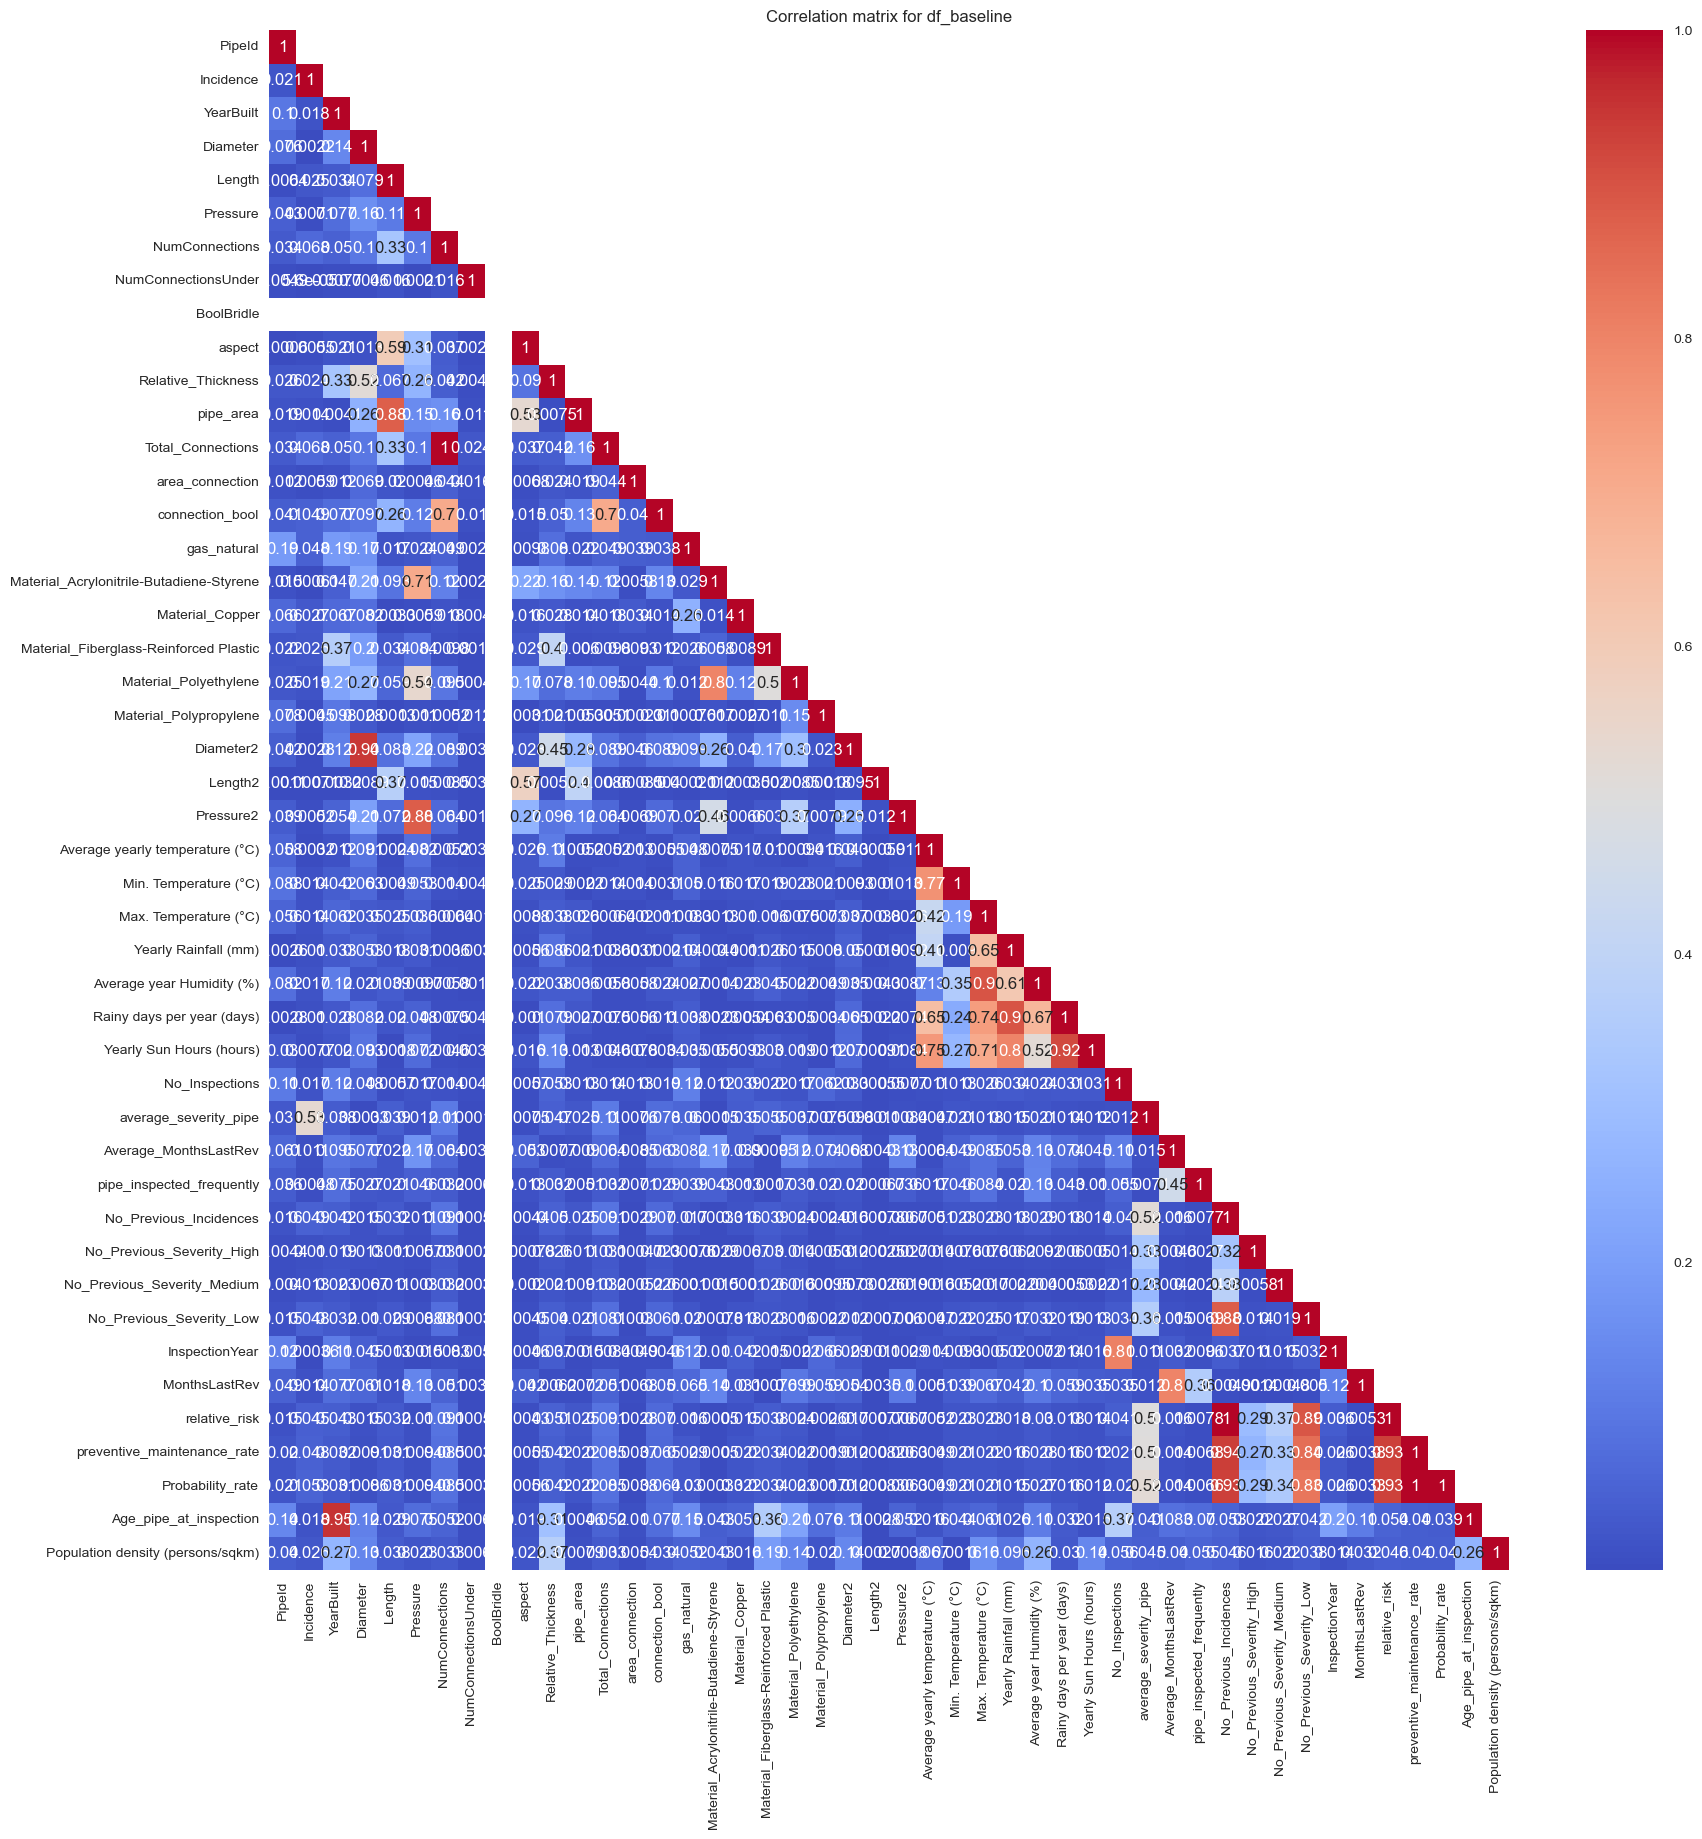

In [36]:
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', mask=np.triu(corr_matrix, k=1))
plt.title('Correlation matrix for df_baseline')
plt.show()

<a id='5'></a>
# <font color=green> 5. Splitting</font>


## <font color=green> 5.1 No Split</font>

We train with the whole dataset and test against kaggle directly, this will be applied to the final submmission model

In [37]:
#rename df_baseline as x
X = df_baseline.drop('Incidence', axis=1)
y = df_baseline['Incidence']
X_test = sample_submission.drop('Incidence', axis=1)
y_test = sample_submission['Incidence'] 

To take care of the unbalanced nature we make use of the hyperparameter "unbalanced subsample"

## <font color=green> 5.2 Stratification by undersampling</font>


We perform stratification undersampling. This returns a df with a similar number oif incidences at the expense of narrowing down the dataset to 7000+- rows.

Approach tested and got better results than SMOTE but worse results than training on a non splitted df

In [ ]:
#undersampling the dataset
#df_baseline_undersampling = df_baseline.groupby('Incidence').apply(lambda x: x.sample(df_baseline['Incidence'].value_counts().min(), random_state=42)).reset_index(drop=True)

#df_baseline_undersampling['Incidence'].value_counts()


## <font color=green> 5.3 SMOTE</font>


We apply SMOTE to create synthetic features and balance df at the expense of doubling the size. This approach did not yield best results hence is commented out

In [ ]:
#using SMOTE to balance the dataset creating a subset dataset with target y = 'Incidence' and removing Incidence','MonthsLastRev','InspectionDay','PipeId', 'MaintenanceId', 'InspectionYear', 'InspectionDate',  'Province', 'Town', 'YearBuilt' for x
#X = df_baseline.drop(['PipeId','Province', 'Town'], axis=1)
#y = df_baseline['Incidence']
#sm = SMOTE(random_state=42)
#X_res, y_res = sm.fit_resample(X, y)
#X_res.shape,y_res.shape

#create a pandas dataframe with the new balanced dataset
#df_baseline_balanced = pd.DataFrame(X_res, columns=X.columns)
#df_baseline_balanced['Incidence'] = y_res
#df_baseline_balanced.head()


In [ ]:
#using SMOTE to balance the dataset creating a subset dataset with target y = 'Incidence'
#X = df_baseline.drop('Incidence', axis=1)
#y = df_baseline['Incidence']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#sm = SMOTE(random_state=42)
#X_train, y_train = sm.fit_resample(X_train, y_train)

#count values for Incidence in y_train
#y_train.value_counts()

<a id='6'></a>
# <font color=green> 6. Random Forest</font>

We tried first with a basic model and started iterating. Due to the time constraint and size of dataset, performing hyperparameter gridsearch proved to be too computationally expensive so we iterated through a list of parameters in a manual fashion

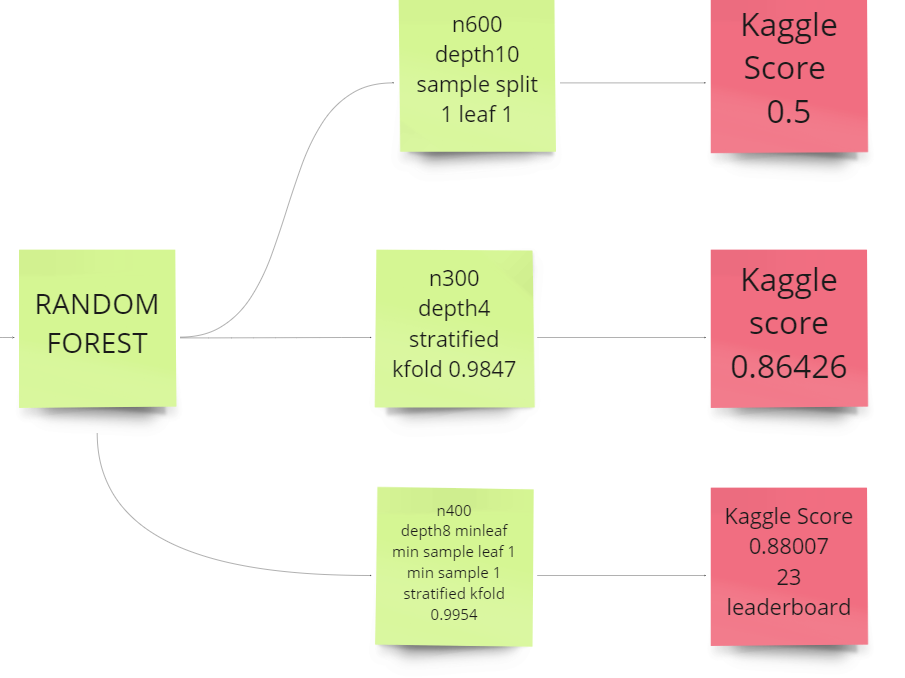

The conclusion of this iterations was that the most we aimed for overfitting, the best the model performed in kaggle

We end up using a depth 9, 600 estimator model as seen bellow

In [ ]:
del train_consolidated

In [40]:
#rfc and cross validation using GridSearchCV to find best parameters and validate with a validation set with InspectionYear 2018 and 2019
rfc = RandomForestClassifier(random_state=42, n_jobs=-1, verbose=2, class_weight='balanced_subsample', 
                             n_estimators=600, max_features='auto', max_depth=9, criterion='gini',
                             min_samples_split=1.0, min_samples_leaf=1)
rfc.fit(X, y)
y_pred = rfc.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 600building tree 2 of 600
building tree 3 of 600

building tree 4 of 600
building tree 5 of 600
building tree 6 of 600
building tree 7 of 600
building tree 8 of 600
building tree 9 of 600
building tree 10 of 600
building tree 11 of 600
building tree 12 of 600
building tree 13 of 600
building tree 14 of 600
building tree 15 of 600
building tree 16 of 600
building tree 17 of 600
building tree 18 of 600
building tree 19 of 600
building tree 20 of 600
building tree 21 of 600
building tree 22 of 600
building tree 23 of 600
building tree 24 of 600
building tree 25 of 600
building tree 26 of 600
building tree 27 of 600
building tree 28 of 600
building tree 29 of 600building tree 30 of 600

building tree 31 of 600
building tree 32 of 600
building tree 33 of 600


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   50.2s


building tree 34 of 600
building tree 35 of 600
building tree 36 of 600
building tree 37 of 600
building tree 38 of 600
building tree 39 of 600
building tree 40 of 600
building tree 41 of 600
building tree 42 of 600building tree 43 of 600
building tree 44 of 600

building tree 45 of 600
building tree 46 of 600
building tree 47 of 600
building tree 48 of 600
building tree 49 of 600building tree 50 of 600

building tree 51 of 600
building tree 52 of 600building tree 53 of 600
building tree 54 of 600

building tree 55 of 600
building tree 56 of 600
building tree 57 of 600
building tree 58 of 600
building tree 59 of 600
building tree 60 of 600
building tree 61 of 600
building tree 62 of 600building tree 63 of 600

building tree 64 of 600
building tree 65 of 600
building tree 66 of 600
building tree 67 of 600
building tree 68 of 600
building tree 69 of 600
building tree 70 of 600
building tree 71 of 600
building tree 72 of 600
building tree 73 of 600
building tree 74 of 600
building tree 75

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.0min


building tree 156 of 600building tree 157 of 600

building tree 158 of 600
building tree 159 of 600building tree 160 of 600

building tree 161 of 600
building tree 162 of 600
building tree 163 of 600
building tree 164 of 600
building tree 165 of 600
building tree 166 of 600building tree 167 of 600

building tree 168 of 600
building tree 169 of 600
building tree 170 of 600
building tree 171 of 600
building tree 172 of 600
building tree 173 of 600
building tree 174 of 600
building tree 175 of 600
building tree 176 of 600
building tree 177 of 600
building tree 178 of 600
building tree 179 of 600
building tree 180 of 600
building tree 181 of 600
building tree 182 of 600
building tree 183 of 600
building tree 184 of 600
building tree 185 of 600
building tree 186 of 600
building tree 187 of 600
building tree 188 of 600
building tree 189 of 600
building tree 190 of 600building tree 191 of 600

building tree 192 of 600
building tree 193 of 600
building tree 194 of 600
building tree 195 of 600


[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  9.0min


building tree 358 of 600
building tree 359 of 600
building tree 360 of 600
building tree 361 of 600building tree 362 of 600

building tree 363 of 600
building tree 364 of 600
building tree 365 of 600
building tree 366 of 600
building tree 367 of 600
building tree 368 of 600
building tree 369 of 600
building tree 370 of 600
building tree 371 of 600
building tree 372 of 600
building tree 373 of 600
building tree 374 of 600
building tree 375 of 600
building tree 376 of 600
building tree 377 of 600
building tree 378 of 600
building tree 379 of 600
building tree 380 of 600
building tree 381 of 600
building tree 382 of 600
building tree 383 of 600
building tree 384 of 600
building tree 385 of 600
building tree 386 of 600
building tree 387 of 600
building tree 388 of 600
building tree 389 of 600
building tree 390 of 600
building tree 391 of 600
building tree 392 of 600
building tree 393 of 600
building tree 394 of 600building tree 395 of 600
building tree 396 of 600

building tree 397 of 600


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 14.9min finished


RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       min_samples_split=1.0, n_estimators=600, n_jobs=-1,
                       random_state=42, verbose=2)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    5.7s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    9.7s finished


<a id='7'></a>
# <font color=green> 7. K-Fold Cross validation</font>

Before submitting to Kaggle, to create a validation set and perform a KFold CV to get an idea on how the model is performing

In [ ]:
#cross validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [ ]:
#use stratified kfold to split the data into train and validation sets

#for train_index, val_index in cv.split(X, y):
#   X_train, X_val = X.iloc[train_index], X.iloc[val_index]
#    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

#fit the model
#rfc.fit(X_train, y_train)

#predict on validation set
#y_pred = rfc.predict(X_val)

#check accuracy score
#accuracy_score(y_val, y_pred)


<a id='8'></a>
# <font color=green> 8. Fitting Model and Results</font>


In [ ]:
predictions = rfc.predict_proba(X_test)
predictions = predictions[:, 1]


In [ ]:
print(accuracy_score(y_test, y_pred)) 

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
#use model to predict on test set
predictions = rfc.predict_proba(X_test)
predictions = predictions[:, 1]

#show accuracy score
print(accuracy_score(y_test, y_pred))

In [41]:
#drop incidence in sample_submission
sample_submission = sample_submission.drop('Incidence', axis=1)

In [42]:
#make predictions for submission using the model
predictions = rfc.predict_proba(sample_submission)
predictions = predictions[:, 1]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    5.9s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:   10.7s finished


In [43]:
#add predictions to submission
sample_submission ['Incidence'] = predictions

#show submission
sample_submission.head(1)

PipeId  YearBuilt  Diameter  Length  Pressure  NumConnections  \
0  446859944       0.82      0.17    0.01      0.00            0.00   

   NumConnectionsUnder  BoolBridle  aspect  Relative_Thickness  pipe_area  \
0                 0.00           0    0.00                0.03       0.00   

   area_connection  connection_bool  gas_natural  \
0             0.00                0            1   

   Material_Acrylonitrile-Butadiene-Styrene  Material_Copper  \
0                                         0                0   

   Material_Fiberglass-Reinforced Plastic  Material_Polyethylene  \
0                                       0                      1   

   Material_Polypropylene  Diameter2  Length2  Pressure2  \
0                       0       0.03     0.00       0.00   

   Average yearly temperature (°C)  Min. Temperature (°C)  \
0                             0.86                   0.77   

   Max. Temperature (°C)  Yearly Rainfall (mm)  Average year Humidity (%)  \
0                   0.64                  0.15                       0.38   

   Rainy days per year (days)  Yearly Sun Hours (hours)  No_Inspections  \
0                        0.20                      0.83            0.36   

   average_severity_pipe  Average_MonthsLastRev  pipe_inspected_frequently  \
0                   1.00                   0.21                       1.00   

   No_Previous_Incidences  No_Previous_Severity_High  \
0                    0.00                       0.00   

   No_Previous_Severity_Medium  No_Previous_Severity_Low  InspectionYear  \
0                         0.00                      0.00            0.00   

   MonthsLastRev  relative_risk  preventive_maintenance_rate  \
0           0.23           0.00                         0.00   

   Probability_rate  Age_pipe_at_inspection  \
0              0.00                    0.17   

   Population density (persons/sqkm)  Incidence  
0                               0.28       0.50

In [44]:
#drop all columns except PipeId and Incidence in submission2 creating kaggle_submission
kaggle_submission = sample_submission.drop(['YearBuilt', 'Diameter', 'Length', 'Pressure',
       'NumConnections', 'NumConnectionsUnder', 'BoolBridle', 'aspect',
       'Relative_Thickness', 'pipe_area', 
       'area_connection', 'connection_bool', 'gas_natural',
       'Material_Acrylonitrile-Butadiene-Styrene', 'Material_Copper',
       'Material_Fiberglass-Reinforced Plastic', 'Material_Polyethylene',
       'Material_Polypropylene', 'Diameter2', 'Length2', 'Pressure2',
       'Average yearly temperature (°C)', 'Min. Temperature (°C)',
       'Max. Temperature (°C)', 'Yearly Rainfall (mm)',
       'Average year Humidity (%)', 'Rainy days per year (days)',
       'Yearly Sun Hours (hours)', 'No_Inspections', 'average_severity_pipe',
       'Average_MonthsLastRev', 'pipe_inspected_frequently',
       'No_Previous_Incidences', 'No_Previous_Severity_High',
       'No_Previous_Severity_Medium', 'No_Previous_Severity_Low',
       'InspectionYear', 'MonthsLastRev', 'relative_risk',
       'preventive_maintenance_rate', 'Probability_rate',
       'Age_pipe_at_inspection','Population density (persons/sqkm)'], axis=1)


In [45]:
#show kaggle_submission
kaggle_submission.head(10)

PipeId  Incidence
0  446859944       0.50
1  428124500       0.50
2  438428871       0.50
3  429034569       0.50
4  411184477       0.50
5  428837983       0.50
6  428837841       0.50
7  428838331       0.50
8    1200432       0.50
9    1200564       0.50

In [46]:
kaggle_submission.shape

(909733, 2)

In [ ]:
#export kaggle_submission to csv
os.chdir(r"C:\Users\JuanHorrillo\OneDrive - IE Students\Documents\Masters\Sustainability\csvs\230222")

kaggle_submission.to_csv('kaggle_submission_rf9_600_sampleleaf1.csv', index=False)

<a id='8'></a>
# <font color=green> 9. Getting additional baselines</font>

In [ ]:
#using lazypredict to  find the best model to predict on the dataset
from lazypredict.Supervised import LazyClassifier
clf = LazyClassifier(verbose=1, ignore_warnings=False, custom_metric=None, predictions=True, random_state=42, n_jobs=-1)
models, predictions = clf.fit(X_train, X_train, X_test, y_test)
models


### ==========================================================================
## End of Notebook 5: Random Forest (5/6)
### ==========================================================================